### 데이터 로드 및 확인
- **MIT-BIH 심전도 데이터셋** 불러오기  
- 각 샘플은 187 포인트 길이의 ECG 파형으로 구성  
- **타깃 변수**: 0 = 정상, 1 = 비정상

In [13]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# 경로
DATA_DIR = Path(".")           
OUT_FIG  = Path("../figures")
OUT_DATA = Path("../data")
OUT_FIG.mkdir(parents=True, exist_ok=True)
OUT_DATA.mkdir(parents=True, exist_ok=True)

tr = pd.read_csv(DATA_DIR / "mitbih_train.csv", header=None)
te = pd.read_csv(DATA_DIR / "mitbih_test.csv", header=None)
df = pd.concat([tr, te], axis=0, ignore_index=True)

print("원본 형태:", df.shape)

원본 형태: (109446, 188)


In [6]:
print(df.head())

        0         1         2         3         4         5         6    \
0  0.977941  0.926471  0.681373  0.245098  0.154412  0.191176  0.151961   
1  0.960114  0.863248  0.461538  0.196581  0.094017  0.125356  0.099715   
2  1.000000  0.659459  0.186486  0.070270  0.070270  0.059459  0.056757   
3  0.925414  0.665746  0.541436  0.276243  0.196133  0.077348  0.071823   
4  0.967136  1.000000  0.830986  0.586854  0.356808  0.248826  0.145540   

        7         8         9    ...  178  179  180  181  182  183  184  185  \
0  0.085784  0.058824  0.049020  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
1  0.088319  0.074074  0.082621  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
2  0.043243  0.054054  0.045946  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
3  0.060773  0.066298  0.058011  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4  0.089202  0.117371  0.150235  ...  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

   186  187  
0  0.0  0.0  
1  0.0  0.0  
2  0.0  0.0  
3  0.0  0.0 

In [7]:
print(df[187].value_counts())

187
0.0    90589
4.0     8039
2.0     7236
1.0     2779
3.0      803
Name: count, dtype: int64


### 데이터 분리
- **입력 변수 (X)**: 마지막 열을 제외한 187개의 시계열 포인트 (ECG 파형 값)  
- **원본 라벨 (y_raw)**: 마지막 열, 0~4 범위의 다중 클래스 (총 5종)  
- **타깃 라벨 (y)**: 분석 단순화를 위해 이진화 처리  
  - 0 = 정상 (Normal)  
  - 1 = 비정상 (Abnormal)  

> 따라서 최종적으로 X는 `(샘플 수, 187)`, y는 `(샘플 수,)` 형태를 가지며,  
> 정상/비정상 이진 분류 문제로 변환됨.

In [14]:
X = df.iloc[:, :-1].values.astype(np.float32)
y_raw = df.iloc[:, -1].values.astype(int)
y = (y_raw != 0).astype(int)

print(f"[load] MIT-BIH (5-class → binary)")
print("데이터 형태:", X.shape, y.shape)

[load] MIT-BIH (5-class → binary)
데이터 형태: (109446, 187) (109446,)


### 결측치와 무한값을 0으로 바꿔 데이터 정리

In [16]:
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

In [23]:
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y, columns=["label"])

X_path = OUT_DATA / "X_processed.csv"
y_path = OUT_DATA / "y_processed.csv"

X_df.to_csv(X_path, index=False)
y_df.to_csv(y_path, index=False)

print(f"Saved: {X_path}, {y_path}")

Saved: ../data/X_processed.csv, ../data/y_processed.csv


### 클래스 분포 확인 및 시각화
- 정상 클래스가 대다수 → 데이터 불균형 존재  
- Abnormal 비율 약 17% 수준

In [9]:
vals, cnts = np.unique(y, return_counts=True)
dist = {int(k): int(v) for k, v in zip(vals, cnts)}
pos_rate = cnts[vals.tolist().index(1)] / y.size if 1 in vals else 0.0
print(f"클래스 분포: {dist} (Abnormal 비율={pos_rate:.3f})")

클래스 분포: {0: 90589, 1: 18857} (Abnormal 비율=0.172)


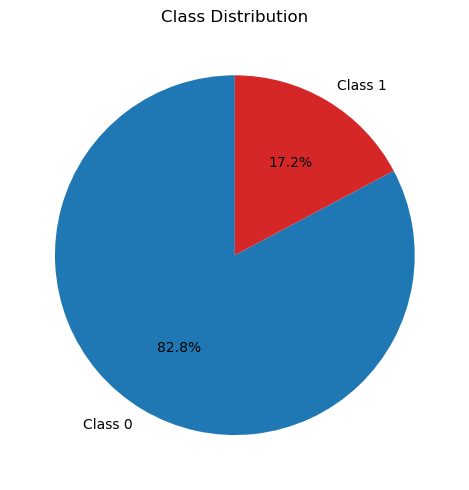

In [10]:
plt.figure(figsize=(5,5))
plt.pie(cnts, labels=[f"Class {int(k)}" for k in vals], 
        autopct="%.1f%%", startangle=90, colors=["tab:blue", "tab:red"])
plt.title("Class Distribution")
plt.tight_layout()
plt.savefig(OUT_FIG / "ecg_class_distribution_pie.png", dpi=150)
plt.show()

### 무작위 파형 시각화
- 클래스별 파형 3개를 랜덤 추출  
- 원시 신호에서는 P-QRS-T 패턴이 분명하지 않지만, 정상·비정상 간 진폭·형태 변이 차이를 확인 가능

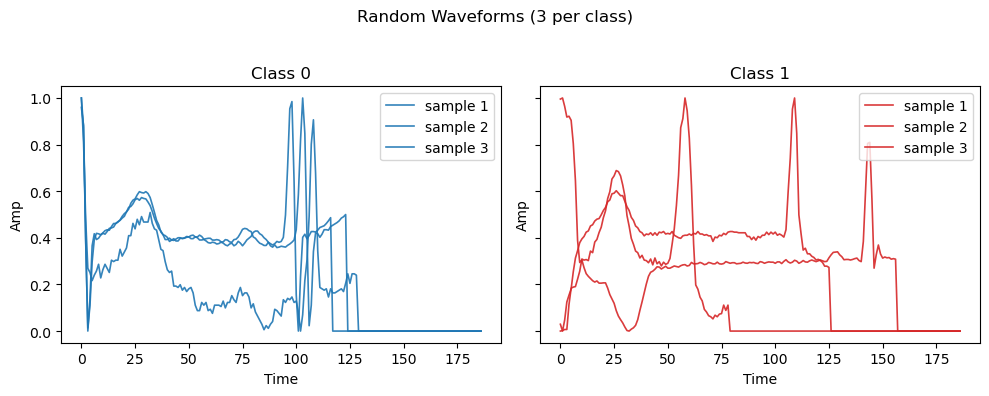

In [16]:
rng = np.random.default_rng(12)
fig, axes = plt.subplots(1,2, figsize=(10,4), sharey=True)
for ax, (cls, color) in zip(axes, [(0,"tab:blue"), (1,"tab:red")]):
    idx = np.where(y==cls)[0]
    pick = rng.choice(idx, size=min(3, len(idx)), replace=False)
    for i,p in enumerate(pick):
        ax.plot(X[p], alpha=0.9, lw=1.2, label=f"sample {i+1}", color=color)
    ax.set_title(f"Class {cls}")
    ax.set_xlabel("Time"); ax.set_ylabel("Amp")
    ax.legend()
fig.suptitle("Random Waveforms (3 per class)")
fig.tight_layout(rect=[0, 0, 1, 0.95])          
fig.savefig(OUT_FIG / "ecg_random_waveforms.png", dpi=150, bbox_inches='tight')
plt.show()
plt.close(fig)

### 클래스별 평균 ± 표준편차 파형
- 정상(0): 비교적 일정한 진폭과 주기성  
- 비정상(1): 평균 파형의 변동 폭이 크고, 표준편차가 넓게 분포 → 신호 다양성이 더 큼

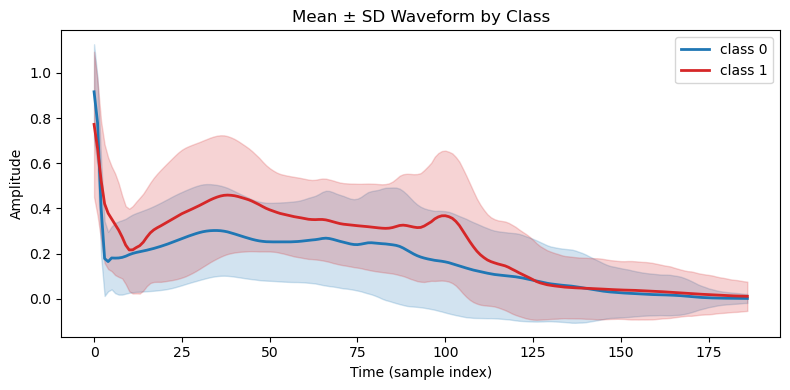

In [17]:
plt.figure(figsize=(8,4))
for cls, color in [(0,"tab:blue"), (1,"tab:red")]:
    Xc = X[y==cls]
    mu = Xc.mean(axis=0)
    sd = Xc.std(axis=0)
    xax = np.arange(Xc.shape[1])
    plt.plot(xax, mu, color=color, lw=2, label=f"class {cls}")
    plt.fill_between(xax, mu-sd, mu+sd, color=color, alpha=0.2)
plt.title("Mean ± SD Waveform by Class")
plt.xlabel("Time (sample index)"); plt.ylabel("Amplitude")
plt.legend()
plt.tight_layout()
plt.savefig(OUT_FIG / "ecg_mean_std_waveforms.png", dpi=150, bbox_inches='tight')
plt.show()
plt.close()

### 결론
- **데이터 불균형** 존재 → 모델링 시 가중치 조정(class_weight) 또는 샘플링 기법(SMOTE 등) 필요  
- **원시 파형만으로는 클래스 간 차이가 뚜렷하지 않음**  
- 그러나, **통계적 특성(mean, std 등)이나 ECG 도메인 특성(QRS, RR 간격 등)을 추출**하면 분류 가능성 충분